# 03 —  SHAP Analysis

## 1. Overview

In this notebook, I use SHAP (SHapley Additive exPlanations) to open up the “black box” of the models trained in the previous stages of the project. SHAP provides a unified, theoretically grounded framework for attributing model predictions to individual features, allowing me to examine both global patterns and local decision‑making behavior.

The goal of this notebook is to conduct a comprehensive interpretability analysis across regimes, within regimes, and within specific subgroups of the population. Each regime represents a distinct data environment or behavioral context, and SHAP allows me to compare how feature importance shifts as the underlying data distribution changes. By examining SHAP values across regimes, I can identify which predictors consistently drive model performance and which ones are regime‑specific.

Within each regime, I also explore subgroup‑level SHAP analyses. These subgroups may reflect demographic characteristics, behavioral clusters, or other meaningful partitions of the data. By comparing SHAP distributions across subgroups, I can assess whether the model behaves equitably, whether certain features matter more for some groups than others, and whether the model relies on different signals depending on subgroup membership.

To quantify these differences, I compute:

* Spearman rank correlations of feature importance across regimes and subgroups
This reveals how stable the ranking of influential features is across different contexts. High correlations indicate consistent model behavior; low correlations suggest regime‑ or subgroup‑specific dynamics.

* Variance of SHAP values across regimes and subgroups
This helps identify features whose influence fluctuates substantially depending on the data environment or population segment. High variance features may indicate instability, heterogeneity, or context‑dependent effects.

In [5]:
import sys
import os
import joblib

# Determine the project root (one level above the notebook directory)
project_root = os.path.abspath("..")

# Add project root to Python path so modules in /src can be imported
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

# Build data directory path
data_dir = os.path.join(project_root, "data")
print("Data directory:", data_dir)


Project root added: C:\Users\shari\OneDrive\MSc Data Science and Society\Thesis_DSS_2026
Data directory: C:\Users\shari\OneDrive\MSc Data Science and Society\Thesis_DSS_2026\data


## 2. Imports

In [7]:

import numpy as np
import pandas as pd

# ============================================
# Visualization
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Improve plot aesthetics
sns.set(style="whitegrid", context="notebook")

# ============================================
# SHAP Explainability
# ============================================
import shap

# Initialize JS visualization for notebooks
shap.initjs()

# ============================================
# Model Loading / Saving
# ============================================
import pickle
import os

# ============================================
# Project Modules
# ============================================
from src.modeling import run_all_models_for_regime
from src.config import GLOBAL_CONFIG
from src.transforms import inverse_target_corrected
from src.feature_engineering import build_preprocessor
from src.feature_filtering import drop_high_missing_cols, drop_constant_and_near_constant_cols

from src.shap_analysis import (
    compute_shap_xgb_per_regime,
    compute_across_regime_shap_common_features,
    summarize_volatile_stable_features,
    safe_save_plot
)

# ============================================
# Optional: Warnings Control
# ============================================
import warnings
warnings.filterwarnings("ignore")


## 3. Load Results

In [9]:

ALL_RESULTS = joblib.load("results/all_results.joblib")

## 3.  Run Within-Regime SHAP Analysis


Computing SHAP for regime: Regime A

Mean Absolute SHAP Values (Top 15 Features):


Reason <36h: family situation               1.790348
Supervises employees                        1.391389
Reason <36h: other                          1.138012
Reason <36h: no opportunity to work more    1.028782
Occupation (first job)                      0.884097
Reason <36h: home activities                0.852027
Commute to work (minutes)                   0.687263
Sector                                      0.675159
Reason <36h: more leisure                   0.674023
Weekend work frequency                      0.616395
Age                                         0.582615
Has sideline job                            0.514685
Works less to care for children             0.509227
Reason <36h: health                         0.487301
Missing: took job courses                   0.484880
dtype: float32

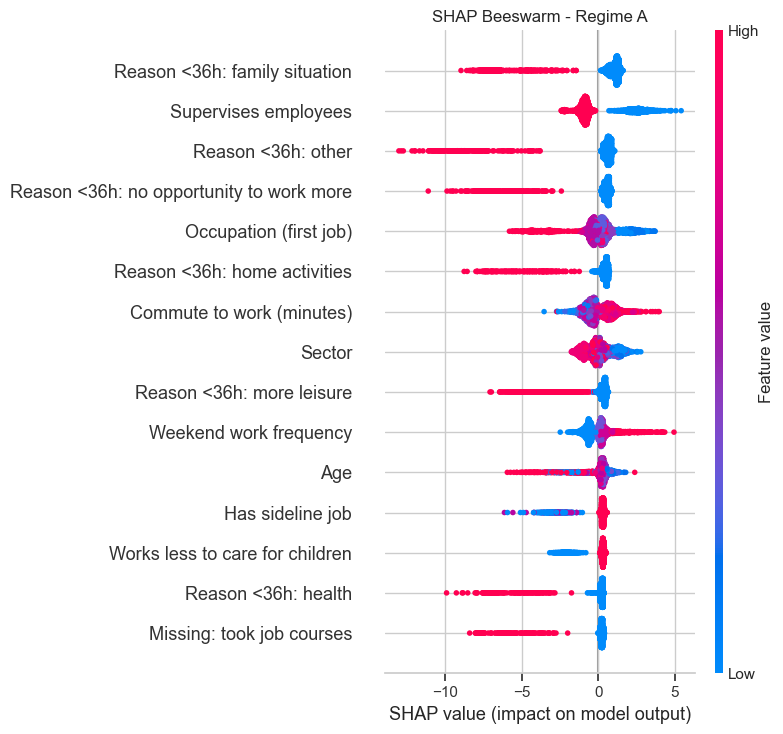

Beeswarm saved to: shap_plots\Regime A\shap_beeswarm_Regime A.png

Computing SHAP for regime: Regime B

Mean Absolute SHAP Values (Top 15 Features):


Missing: took job courses                   1.520479
Reason <36h: family situation               1.330155
Reason <36h: no opportunity to work more    1.245032
Supervises employees                        1.006739
Reason <36h: other                          0.904380
Sector                                      0.874830
Age                                         0.840003
Minimum wage offer (EUR)                    0.821416
Occupation (first job)                      0.791456
Reason <36h: more leisure                   0.682711
Reason <36h: home activities                0.658917
Weekend work frequency                      0.579480
Commute to work (minutes)                   0.503991
Has sideline job                            0.472331
Workplace size                              0.440143
dtype: float32

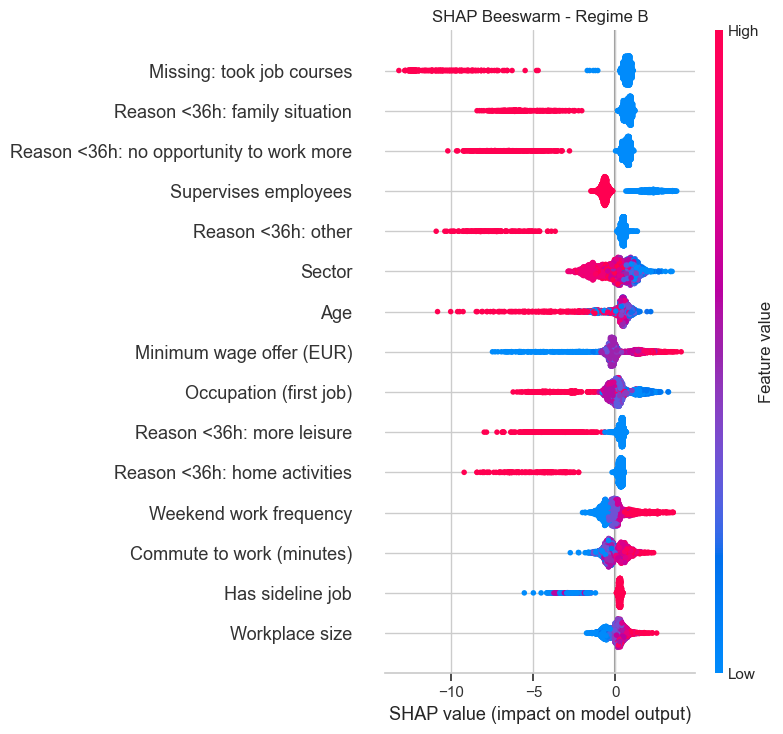

Beeswarm saved to: shap_plots\Regime B\shap_beeswarm_Regime B.png

Computing SHAP for regime: Regime C

Mean Absolute SHAP Values (Top 15 Features):


Reason <36h: family situation               1.154888
Missing: took job courses                   1.065991
Age                                         0.957710
Supervises employees                        0.876782
Weekly home-work hours                      0.860287
Reason <36h: more leisure                   0.806060
Reason <36h: other                          0.766652
Profession (ISCO 085)                       0.669658
Reason <36h: no opportunity to work more    0.665061
Sector                                      0.569062
Has sideline job                            0.564999
Weekend work frequency                      0.563409
Reason <36h: home activities                0.532906
Reason <36h: health                         0.496761
Missing: desired part-time hours            0.469492
dtype: float32

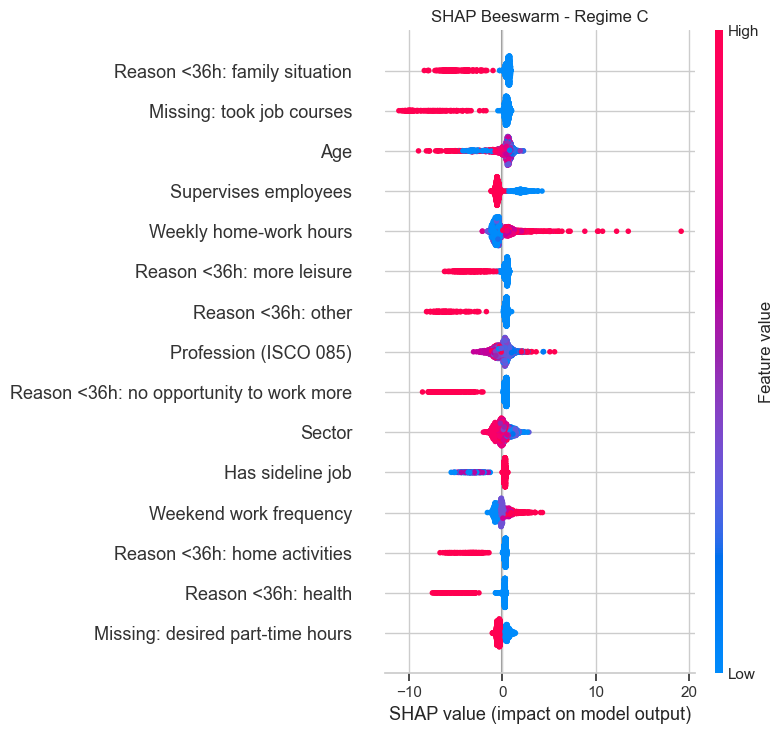

Beeswarm saved to: shap_plots\Regime C\shap_beeswarm_Regime C.png


In [11]:
 
feature_name_map = {
    "num__143": "Has sideline job",
    "num__409": "Supervises employees",
    "num__446": "Works less to care for children",
    "binary__391": "Reason <36h: family situation",
    "binary__390": "Reason <36h: no opportunity to work more",
    "binary__393": "Reason <36h: home activities",
    "binary__401": "Reason <36h: other",
    "binary__400": "Reason <36h: more leisure",
    "binary__088": "Currently employed",
    "num__404": "Occupation (first job)",
    "num__402": "Sector",
    "num__122": "Retirement feeling",
    "num__289": "Expected retirement age",
    "num__008": "Education completed (2nd degree)",
    "num__479": "Savings deposit (2007)",
    "num__384": "Max full-time wage estimate",
    "num__136": "Commute to work (minutes)",
    "num__032": "Education–work match scale",
    "num__003": "Age",

    # NEW VARIABLES YOU LISTED
    "num__022": "Preferred retirement age",
    "num__459": "Lifecourse deposit (2007)",
    "num__438": "No children or grandchildren",
    "num__450": "Provides informal care",
    "num__123": "Organisation type (first job)",
    "num__035": "Has taken job courses",
    "binary__437": "Has grandchildren",
    "binary__492": "Reason <36h: family/health",

    # Missing indicators
    "num__missingindicator_141": "Missing: weekend work frequency",
    "num__missingindicator_142": "Missing: evening work frequency",
    "num__missingindicator_517": "Missing: minimum wage offer",
    "num__missingindicator_405": "Missing: occupation (first job)",
    "num__missingindicator": "Missing: irregular work hours",  # if this is the real column name

    # Existing ones
    "num__411": "Option to continue working after pension",
    "num__missingindicator_411": "Missing: option to continue after pension",
    "num__missingindicator_134": "Missing: year started working",
    "num__517": "Minimum wage offer (EUR)",
    "num__missingindicator_035": "Missing: took job courses",
    "num__missingindicator_528": "Missing: workplace size",
    "num__611": "Profession (ISCO 085)",
    "num__missingindicator_309": "Missing: desired part-time hours",
    "num__missingindicator_136": "Missing: commute to work (minutes)",
    "num__005": "Highest Dutch education",
    "num__308": "Retirement transition preference",
    "num__610": "Weekly home-work hours",
    "num__309": "Desired part-time hours",
    "num__134": "Year started working",
    "num__528": "Workplace size",
    "num__141": "Weekend work frequency",
    "binary__395": "Reason <36h: health"
}

shap_results_per_regime = {}

for regime_name, result_dict in ALL_RESULTS.items():
    print(f"\nComputing SHAP for regime: {regime_name}")
    
    shap_results_per_regime[regime_name] = compute_shap_xgb_per_regime(
        result_dict['results'],
        regime_name=regime_name,
        model_name="XGBoost",
        output_dir=os.path.join("shap_plots", regime_name),
        feature_name_map=feature_name_map
    )


## 4. Run Across-Regime SHAP Analysis


Common Features Across Regimes (63 raw features):


['binary__088',
 'binary__095',
 'binary__096',
 'binary__101',
 'binary__102',
 'binary__390',
 'binary__391',
 'binary__392',
 'binary__393',
 'binary__394',
 'binary__395',
 'binary__396',
 'binary__397',
 'binary__398',
 'binary__399',
 'binary__400',
 'binary__401',
 'binary__436',
 'binary__437',
 'binary__438',
 'num__003',
 'num__005',
 'num__008',
 'num__035',
 'num__122',
 'num__123',
 'num__134',
 'num__136',
 'num__140',
 'num__141',
 'num__142',
 'num__143',
 'num__288',
 'num__289',
 'num__402',
 'num__404',
 'num__405',
 'num__409',
 'num__411',
 'num__439',
 'num__446',
 'num__450',
 'num__528',
 'num__missingindicator_008',
 'num__missingindicator_035',
 'num__missingindicator_122',
 'num__missingindicator_134',
 'num__missingindicator_136',
 'num__missingindicator_140',
 'num__missingindicator_141',
 'num__missingindicator_142',
 'num__missingindicator_143',
 'num__missingindicator_288',
 'num__missingindicator_289',
 'num__missingindicator_402',
 'num__missingindicat


Common Features (Readable Names):


['Currently employed',
 'binary__095',
 'binary__096',
 'binary__101',
 'binary__102',
 'Reason <36h: no opportunity to work more',
 'Reason <36h: family situation',
 'binary__392',
 'Reason <36h: home activities',
 'binary__394',
 'Reason <36h: health',
 'binary__396',
 'binary__397',
 'binary__398',
 'binary__399',
 'Reason <36h: more leisure',
 'Reason <36h: other',
 'binary__436',
 'Has grandchildren',
 'binary__438',
 'Age',
 'Highest Dutch education',
 'Education completed (2nd degree)',
 'Has taken job courses',
 'Retirement feeling',
 'Organisation type (first job)',
 'Year started working',
 'Commute to work (minutes)',
 'num__140',
 'Weekend work frequency',
 'num__142',
 'Has sideline job',
 'num__288',
 'Expected retirement age',
 'Sector',
 'Occupation (first job)',
 'num__405',
 'Supervises employees',
 'Option to continue working after pension',
 'num__439',
 'Works less to care for children',
 'Provides informal care',
 'Workplace size',
 'num__missingindicator_008',
 '


Mean Absolute SHAP Values for Common Features (Readable Names):


,Regime A,Regime B,Regime C
Currently employed,0.022012,0.018524,0.026280
binary__095,0.335432,0.022434,0.085556
binary__096,0.283350,0.261257,0.087120
binary__101,0.141471,0.031253,0.056918
binary__102,0.083075,0.076128,0.022216
...,...,...,...
Missing: option to continue after pension,0.346716,0.056020,0.066560
num__missingindicator_439,0.024225,0.027031,0.028667
num__missingindicator_446,0.027203,0.054483,0.024386
num__missingindicator_450,0.029451,0.080482,0.008873



Spearman Correlation of Feature Ranks Across Regimes:


,Regime A,Regime B,Regime C
Regime A,1.000000,0.799539,0.840774
Regime B,0.799539,1.000000,0.809956
Regime C,0.840774,0.809956,1.000000



Rank Variance Across Regimes:


,Rank Variance
Missing: year started working,403.000000
binary__095,325.333333
Missing: weekend work frequency,324.333333
Missing: workplace size,321.333333
Missing: option to continue after pension,254.333333
...,...
num__missingindicator_122,0.333333
num__missingindicator_289,0.333333
Weekend work frequency,0.333333
Reason <36h: family situation,0.333333



Beeswarm for regime: Regime A


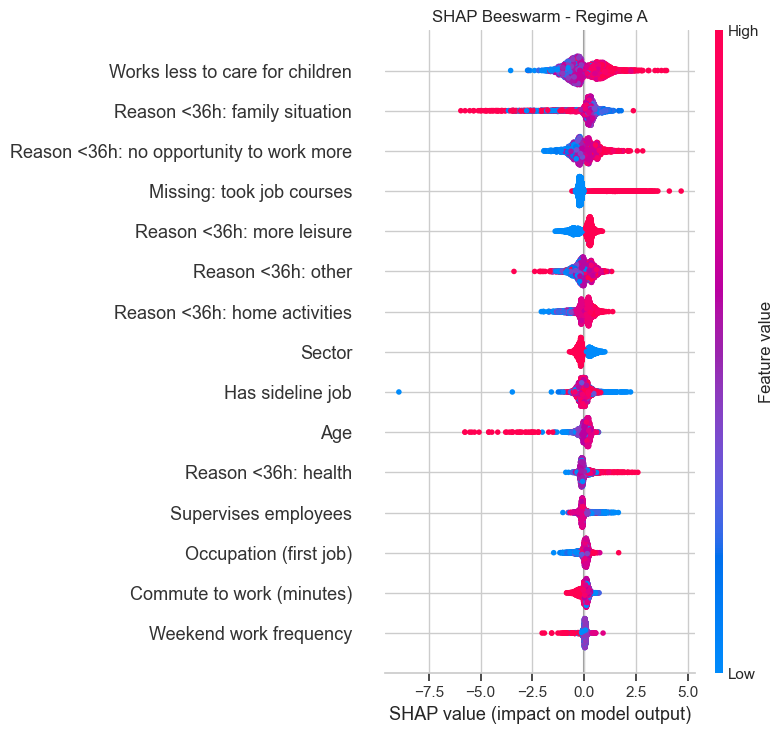

Saved beeswarm to: shap_across_regimes\shap_beeswarm_Regime A.png

Beeswarm for regime: Regime B


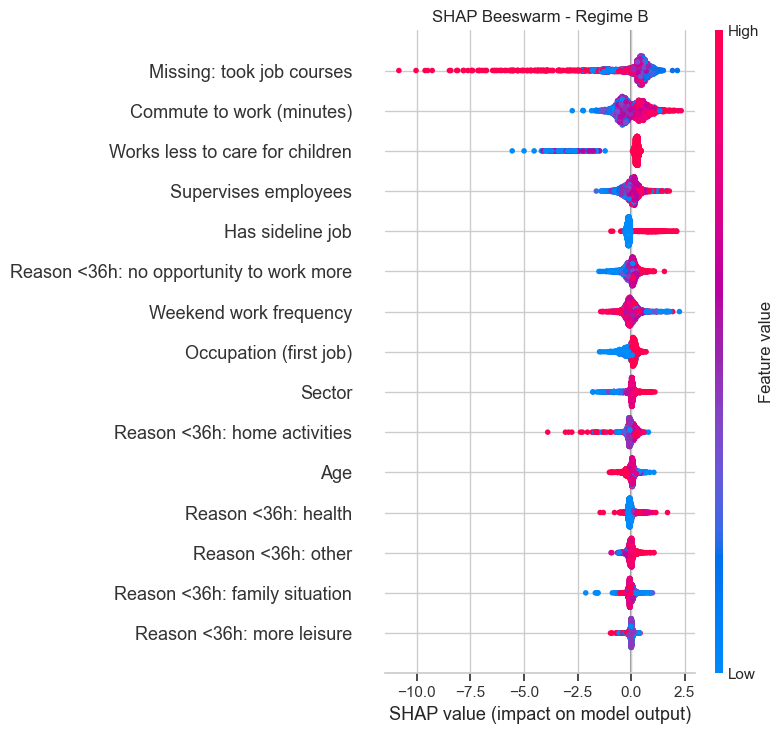

Saved beeswarm to: shap_across_regimes\shap_beeswarm_Regime B.png

Beeswarm for regime: Regime C


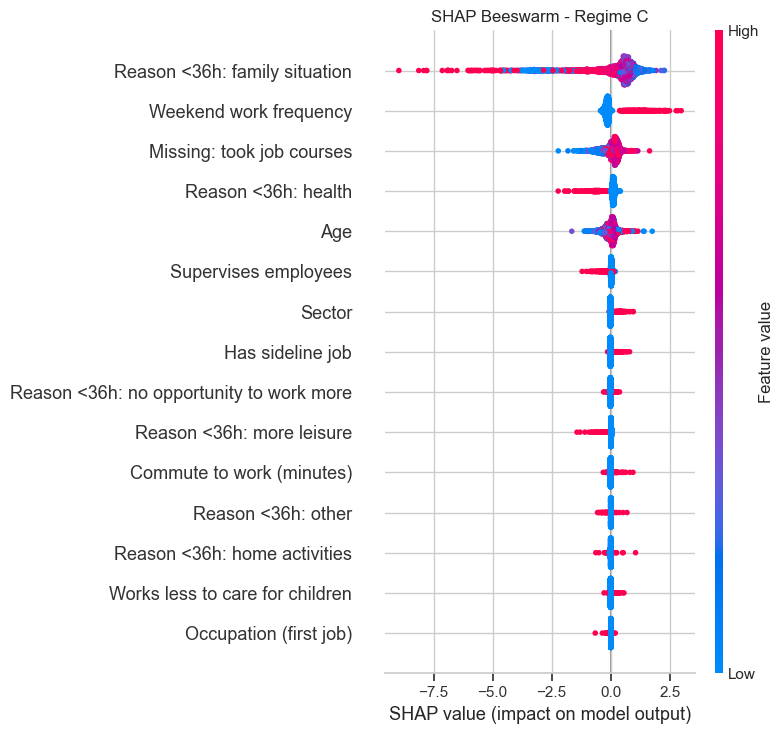

Saved beeswarm to: shap_across_regimes\shap_beeswarm_Regime C.png


In [13]:
across_regime_results = compute_across_regime_shap_common_features(
    shap_results_per_regime,
    top_n_features=15,
    output_dir="shap_across_regimes",
    feature_name_map=feature_name_map
)


In [14]:
# Assuming you have already run across-regime SHAP:
volatile_stable_tables = summarize_volatile_stable_features(across_regime_results, top_n=10)


Top Volatile Features Across Regimes (High Rank Variance):


,Regime A,Regime B,Regime C,Rank Variance
num__missingindicator_134,0.011665,0.284317,0.078065,403.000000
binary__095,0.335432,0.022434,0.085556,325.333333
num__missingindicator_141,0.011799,0.189631,0.004896,324.333333
num__missingindicator_528,0.005509,0.171833,0.008463,321.333333
num__missingindicator_411,0.346716,0.056020,0.066560,254.333333
num__missingindicator_140,0.299233,0.291217,0.062726,212.333333
num__missingindicator_136,0.033778,0.120323,0.255493,199.000000
num__missingindicator_409,0.012647,0.077889,0.147399,196.333333
binary__438,0.183803,0.160257,0.024826,154.333333
num__missingindicator_405,0.142189,0.103564,0.336548,134.333333



Top Stable Features Across Regimes (Low Rank Variance):


,Regime A,Regime B,Regime C,Rank Variance
num__missingindicator_008,0.003802,0.002454,0.000000,0.000000
binary__391,1.790348,1.330155,1.154888,0.333333
num__141,0.616395,0.579480,0.563409,0.333333
num__missingindicator_289,0.011942,0.017564,0.009537,0.333333
num__missingindicator_122,0.159495,0.133922,0.111401,0.333333
num__409,1.391389,1.006739,0.876782,1.333333
num__402,0.675159,0.874830,0.569062,1.333333
binary__401,1.138012,0.904380,0.766652,2.333333
num__446,0.509227,0.341543,0.408450,2.333333
binary__395,0.487301,0.436377,0.496761,2.333333


In [15]:
volatile_stable_results = summarize_volatile_stable_features(
    across_regime_results,
    top_n=10,
    feature_name_map=feature_name_map
)



Top Volatile Features Across Regimes (High Rank Variance):


,Regime A,Regime B,Regime C,Rank Variance
Missing: year started working,0.011665,0.284317,0.078065,403.000000
binary__095,0.335432,0.022434,0.085556,325.333333
Missing: weekend work frequency,0.011799,0.189631,0.004896,324.333333
Missing: workplace size,0.005509,0.171833,0.008463,321.333333
Missing: option to continue after pension,0.346716,0.056020,0.066560,254.333333
num__missingindicator_140,0.299233,0.291217,0.062726,212.333333
Missing: commute to work (minutes),0.033778,0.120323,0.255493,199.000000
num__missingindicator_409,0.012647,0.077889,0.147399,196.333333
binary__438,0.183803,0.160257,0.024826,154.333333
Missing: occupation (first job),0.142189,0.103564,0.336548,134.333333



Top Stable Features Across Regimes (Low Rank Variance):


,Regime A,Regime B,Regime C,Rank Variance
num__missingindicator_008,0.003802,0.002454,0.000000,0.000000
Reason <36h: family situation,1.790348,1.330155,1.154888,0.333333
Weekend work frequency,0.616395,0.579480,0.563409,0.333333
num__missingindicator_289,0.011942,0.017564,0.009537,0.333333
num__missingindicator_122,0.159495,0.133922,0.111401,0.333333
Supervises employees,1.391389,1.006739,0.876782,1.333333
Sector,0.675159,0.874830,0.569062,1.333333
Reason <36h: other,1.138012,0.904380,0.766652,2.333333
Works less to care for children,0.509227,0.341543,0.408450,2.333333
Reason <36h: health,0.487301,0.436377,0.496761,2.333333


## 6. Save Results

In [17]:
import pickle
import os

# Define the folder where you want to save the results
output_dir = "shap_results_saved"

# Make sure the folder exists
os.makedirs(output_dir, exist_ok=True)

# Save across-regime results
with open(f"{output_dir}/across_regime_results.pkl", "wb") as f:
    pickle.dump(across_regime_results, f)

# Save within-regime results
with open(f"{output_dir}/within_regime_results.pkl", "wb") as f:
    pickle.dump(shap_results_per_regime, f)
